In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from keras.layers import LSTM

%matplotlib inline

In [74]:
path_ds1_forcast = "data/Dateset#1/Dataset1_forecast.csv"
path_ds1_measure = "data/Dateset#1/Dataset1_measurement.csv"

path_ds2_forcast = "data/Dateset#2/Dataset2_forecast.csv"
path_ds2_measure = "data/Dateset#2/Dataset2_measurement.csv"

path_ds3_forcast = "data/Dateset#1/Dataset3_forecast.csv"

In [98]:
def read_csv(data_path, columns):
    data = pd.read_csv(data_path, parse_dates=True)
    data.columns =  columns
    return data

def find_missing_index(data):
    '''
    - data (pandas dataframe): contains missing/nan/null values
    - return a list of distinct missing indices (= set)
    - return None if data has no missing values
    '''
    # select numeric columns only
    columns = data.select_dtypes(include=[np.number]).columns
    missing_indices = set()
    for col in columns:
        indices = data[data[col].isna()].index.values
        for idx in indices:
            missing_indices.add(idx)
    return sorted(list(missing_indices))

def timeseries_plot_all(df):
    '''Show box plots for each feature
    - df is a pandas dataframe whose index is time series,for exmple [2020-10-30 00:00:00, 2020-10-30 00:15:00]
    - The output will show 2 time series graph per row.
    
    '''
    # Select just the numeric features
    df = df.select_dtypes(include=[np.number])
    # Compute the layout grid size
    data_cols = len(df.columns)
    # the size of box
    unit_size = 10
    # 5 box on the same row
    layout_cols = 3
    layout_rows = int(data_cols/layout_cols + layout_cols)
    # Make the plots
    df.plot(subplots=True
            , figsize=(layout_cols*unit_size,layout_rows*unit_size)
            , layout=(layout_rows,layout_cols))
    # Adjust the legend position here        
    plt.legend(loc='upper right')
    plt.show()

def find_invalid_data(data):
    '''
    - data (pandas dataframe): contains missing/nan/null values
    - return a list of distinct missing indices (= set)
    - return None if data has no missing values
    '''
    # select numeric columns only
    columns = data.select_dtypes(include=[np.object]).columns
    #print(columns)
    missing_indices = set()
    for col in columns:
        indices = data[data[col].str.contains("N")].index.values
        #print(col, indices)
        for idx in indices:
            missing_indices.add(idx)
    return sorted(list(missing_indices))

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # convert dataframe into sequence data
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def split_data(split_point, X, Y):
    #  6.5H data for testing the model

    #split_point = int(6.5 * 12)

    #X = data[["measure_windspeed", "forecast_windspeed", "forcast_windic"]]

    n = len(X)

    X_sequence = series_to_supervised(X).values

    x_train, x_test = X_sequence[: (n - split_point - 1)], X_sequence[- split_point : ]

    #Y = data[["measure_windpower"]]

    y_train, y_test = Y[: (n - split_point - 1)], Y[- split_point : ]

    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))

    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

    return x_train, y_train, x_test, y_test

    #print(x_train.shape, y_train.shape, x_test.shape, y_test.shape )

def create_ts_forcast(x_train, y_train, x_validation, y_validation):
    # design network
    model = Sequential()
    model.add(LSTM(300, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    history = model.fit(x_train
                        , y_train
                        , epochs = 300
                        , batch_size=72
                        , validation_data=(x_validation, y_validation)
                        , verbose=2
                        , shuffle=False)
    return model, history

def plot_loss_history(model, loss_his, x_test, y_test):
    # plot history

    y_pred = model.predict(x_test)

    plt.figure(figsize=(15, 5))
    plt.plot(loss_his.history['loss'], '*', label='train',  color="red")
    plt.plot(loss_his.history['val_loss'], '-', label='test', color="green")
    plt.title("Long Short-Term Memory (LSTM)'s RMSE " + str(np.sqrt(mean_squared_error(y_test, y_pred))))
    plt.legend()
    plt.show()

    
    print("rmse: ", np.sqrt(mean_squared_error(y_test, y_pred)))



# 1) Train model and validate model with dataset 1

## 1.1 Loading data from csv into dataframe

In [76]:
measurement = read_csv(data_path = path_ds1_measure, columns = ["time", "availablemw", "windspeed", "windpower"])
measurement.time = pd.to_datetime(measurement.time)
measurement.head()

,time,availablemw,windspeed,windpower
0,2018-01-01 00:00:00,34.5,11.9,42.5118
1,2018-01-01 00:05:00,34.5,12,42.7067
2,2018-01-01 00:10:00,34.5,12,42.7067
3,2018-01-01 00:15:00,34.5,11.8,42.3044
4,2018-01-01 00:20:00,34.5,11.8,42.3044


In [77]:
forecast = read_csv(data_path = path_ds1_forcast, columns = ["time","windspeed","windic"])
forecast.time = pd.to_datetime(forecast.time)
forecast.head()

,time,windspeed,windic
0,2018-01-01 00:00:00,9.50241,303.854
1,2018-01-01 01:00:00,8.60719,301.083
2,2018-01-01 02:00:00,8.43270,301.583
3,2018-01-01 03:00:00,8.16070,301.586
4,2018-01-01 04:00:00,8.10899,302.583


## 1.2. Cleaning data 

**Check if there is any missing values**

In [78]:
find_missing_index(measurement)

[]

In [79]:
find_missing_index(forecast)

[]

**Find the invalid character in the dataset**

In [80]:
measurement.iloc[find_invalid_data(measurement)]

,time,availablemw,windspeed,windpower
1073,2018-01-04 17:25:00,\N,7.6,16.0383
1901,2018-01-07 14:25:00,\N,11,39.9904
1902,2018-01-07 14:30:00,\N,11.2,40.7016
5300,2018-01-19 09:40:00,\N,\N,\N
6376,2018-01-23 03:20:00,\N,\N,\N
...,...,...,...,...
83123,2018-12-10 19:15:00,\N,8.6,22.641
83124,2018-12-10 19:20:00,\N,8.8,24.2374
85929,2018-12-20 13:05:00,\N,6.1,7.43422
85930,2018-12-20 13:10:00,\N,6.1,7.43422


In [81]:
forecast.iloc[find_invalid_data(forecast)]

,time,windspeed,windic


**Filling the missing data with Linear Interpolation**

In [82]:
measurement.columns

Index(['time', 'availablemw', 'windspeed', 'windpower'], dtype='object')

In [83]:
# replace \N values by np.nan
measurement[["availablemw", "windspeed", "windpower"]] = measurement[["availablemw", "windspeed", "windpower"]].replace(r'\\N', np.nan, regex=True) 
# change data type from object to float
measurement[["availablemw", "windspeed", "windpower"]] = measurement[["availablemw", "windspeed", "windpower"]].astype(np.float)
# do the interpolation
measurement.interpolate(method="linear", inplace = True)
# recheck if the filling is working
measurement.iloc[find_invalid_data(measurement)]
# fill 0 values with Linear interpolation
measurement.windpower = measurement.windpower.replace(0, np.nan)

measurement.interpolate(method='linear', inplace=True)


No handles with labels found to put in legend.


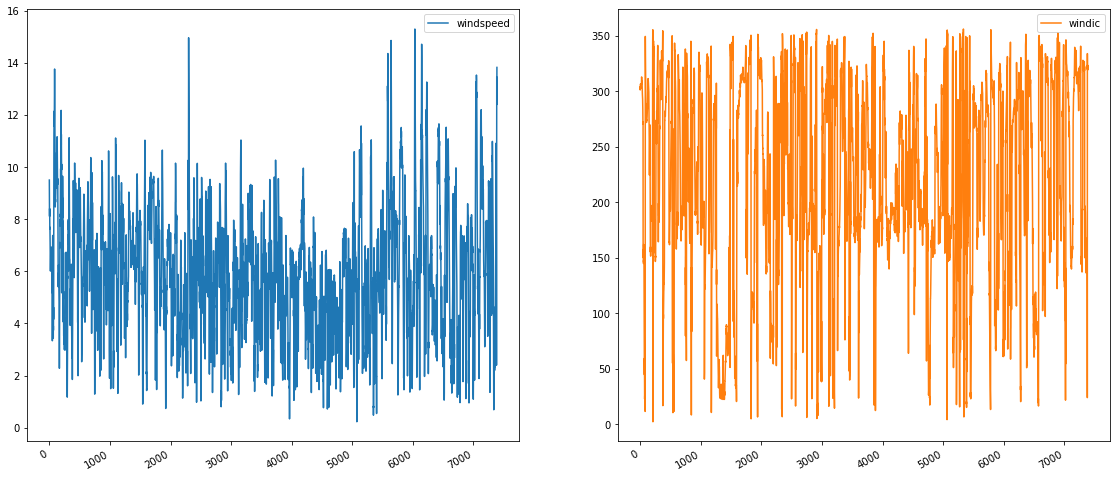

In [85]:
timeseries_plot_all(forecast)

No handles with labels found to put in legend.


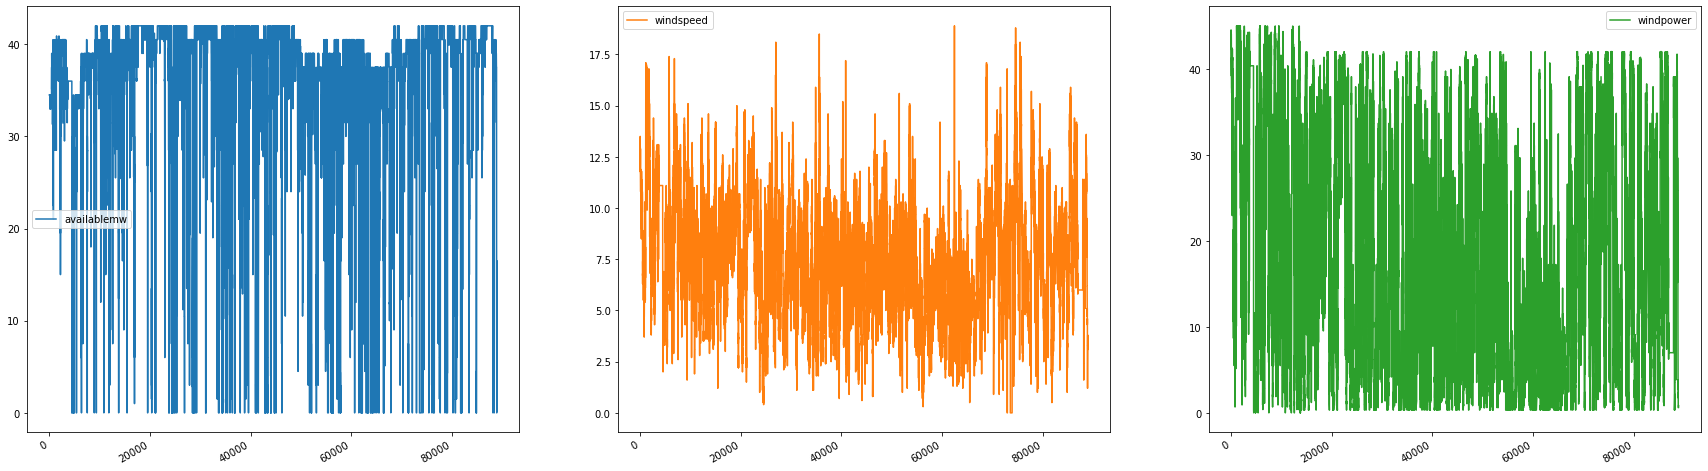

In [86]:
timeseries_plot_all(measurement)

In [87]:
def merge_forecast_measurement(measurement, forecast):
    
    measurement.columns = ['measure_time', 'measure_availablemw', 'measure_windspeed', 'measure_windpower']

    forecast.columns = ['forecast_time', 'forecast_windspeed', 'forcast_windic']
    
    data = measurement.merge(forecast, right_on='forecast_time', left_on = "measure_time", how="left")
    
    data = data[["measure_time", "measure_windspeed", "measure_windpower", "forecast_windspeed","forcast_windic"]]

    # interpolate windspeed and wind direction in forecast data

    data.forecast_windspeed.interpolate(method = "linear", inplace = True)

    data.forcast_windic.interpolate(method = "linear", inplace = True)

    return data



In [88]:
data = merge_forecast_measurement(measurement, forecast)

data.head()

,measure_time,measure_windspeed,measure_windpower,forecast_windspeed,forcast_windic
0,2018-01-01 00:00:00,11.9,42.5118,9.502410,303.854000
1,2018-01-01 00:05:00,12.0,42.7067,9.427808,303.623083
2,2018-01-01 00:10:00,12.0,42.7067,9.353207,303.392167
3,2018-01-01 00:15:00,11.8,42.3044,9.278605,303.161250
4,2018-01-01 00:20:00,11.8,42.3044,9.204003,302.930333


## 1.3 Build machine learning model

### 1.3.1 Split dataset


In [89]:
# 6.5H data for testing the model
split_point = int(6.5 * 12)

X = data[["measure_windspeed", "forecast_windspeed", "forcast_windic"]]
Y = data[["measure_windpower"]]

x_train, y_train, x_test, y_test = split_data(split_point, X, Y)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(88862, 1, 6) (88862, 1) (78, 1, 6) (78, 1)


### 1.3.2 Create Long Short-Term Memory (LSTM) Model


In [92]:
model, loss_his = create_ts_forcast(x_train, y_train, x_test, y_test)

Epoch 1/300
1235/1235 - 17s - loss: 208.5317 - val_loss: 273.1858
Epoch 2/300
1235/1235 - 11s - loss: 181.1421 - val_loss: 267.5193
Epoch 3/300
1235/1235 - 11s - loss: 180.6376 - val_loss: 308.1675
Epoch 4/300
1235/1235 - 11s - loss: 178.7149 - val_loss: 257.8592
Epoch 5/300
1235/1235 - 12s - loss: 181.1708 - val_loss: 308.2758
Epoch 6/300
1235/1235 - 11s - loss: 179.2106 - val_loss: 291.6730
Epoch 7/300
1235/1235 - 11s - loss: 178.1082 - val_loss: 294.5125
Epoch 8/300
1235/1235 - 10s - loss: 180.4651 - val_loss: 285.3544
Epoch 9/300
1235/1235 - 11s - loss: 176.0133 - val_loss: 312.0887
Epoch 10/300
1235/1235 - 12s - loss: 175.7400 - val_loss: 311.7469
Epoch 11/300
1235/1235 - 12s - loss: 177.6250 - val_loss: 275.6956
Epoch 12/300
1235/1235 - 10s - loss: 181.3192 - val_loss: 279.5409
Epoch 13/300
1235/1235 - 10s - loss: 176.5618 - val_loss: 274.2240
Epoch 14/300
1235/1235 - 12s - loss: 171.5410 - val_loss: 256.6708
Epoch 15/300
1235/1235 - 10s - loss: 176.1393 - val_loss: 297.9032
Epoc

### 1.3.3 Model Evaluation using Mean Squared Root Error metrics

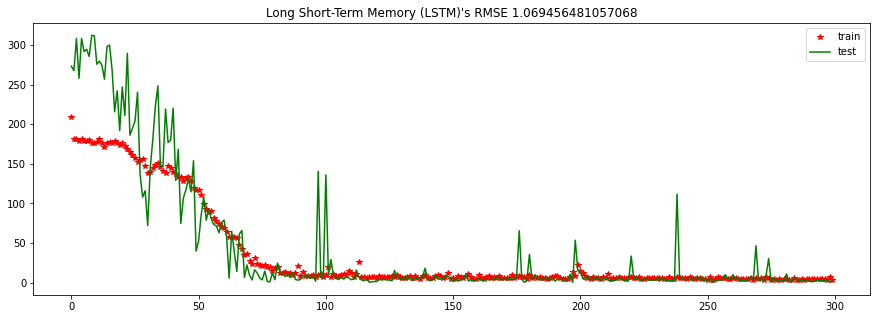

rmse:  1.069456481057068


In [99]:
plot_loss_history(model, loss_his, x_test, y_test)

# 2. Validate the current model with Dataset 2 so see how good it is

## 2. 1 Load csv files of forecast and measurement into dataframe

In [100]:
measurement2 = read_csv(data_path = path_ds2_measure, columns = ["time", "availablemw", "windspeed", "windpower"])
measurement2.time = pd.to_datetime(measurement2.time)

forecast2 = read_csv(data_path = path_ds2_forcast, columns = ["time","windspeed","windic"])
forecast2.time = pd.to_datetime(forecast2.time)

# replace \N values by np.nan
measurement2[["availablemw", "windspeed", "windpower"]] = measurement2[["availablemw", "windspeed", "windpower"]].replace(r'\\N', np.nan, regex=True) 
# change data type from object to float
measurement2[["availablemw", "windspeed", "windpower"]] = measurement2[["availablemw", "windspeed", "windpower"]].astype(np.float)
# do the interpolation
measurement2.interpolate(method="linear", inplace = True)
# recheck if the filling is working
measurement2.iloc[find_invalid_data(measurement2)]
# fill 0 values with Linear interpolation
measurement2.windpower = measurement2.windpower.replace(0, np.nan)

measurement2.interpolate(method='linear', inplace=True)


In [127]:
data2 = merge_forecast_measurement(measurement2, forecast2)

X2 = data2[["measure_windspeed", "forecast_windspeed", "forcast_windic"]]
Y2 = data2[["measure_windpower"]]

x_train2, y_train2, x_test2, y_test2 = split_data(split_point, X2, Y2)

print(x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape)

(8562, 1, 6) (8562, 1) (78, 1, 6) (78, 1)


In [128]:
model2, loss_his2 = create_ts_forcast(x_train2, y_train2, x_test2, y_test2)

Epoch 1/300
119/119 - 6s - loss: 2731.1099 - val_loss: 151.0619
Epoch 2/300
119/119 - 1s - loss: 1822.0712 - val_loss: 597.8904
Epoch 3/300
119/119 - 1s - loss: 1404.6251 - val_loss: 1059.7671
Epoch 4/300
119/119 - 1s - loss: 1273.4950 - val_loss: 1405.1063
Epoch 5/300
119/119 - 1s - loss: 1249.9679 - val_loss: 1454.6104
Epoch 6/300
119/119 - 1s - loss: 1221.0476 - val_loss: 1655.0193
Epoch 7/300
119/119 - 1s - loss: 1214.8784 - val_loss: 1633.9902
Epoch 8/300
119/119 - 1s - loss: 1180.2401 - val_loss: 1598.9567
Epoch 9/300
119/119 - 1s - loss: 1140.1852 - val_loss: 1587.3363
Epoch 10/300
119/119 - 1s - loss: 1099.2039 - val_loss: 1541.9103
Epoch 11/300
119/119 - 1s - loss: 1061.0302 - val_loss: 1445.5823
Epoch 12/300
119/119 - 1s - loss: 1011.8764 - val_loss: 1349.4569
Epoch 13/300
119/119 - 1s - loss: 960.0279 - val_loss: 1268.8907
Epoch 14/300
119/119 - 1s - loss: 923.3051 - val_loss: 1051.5955
Epoch 15/300
119/119 - 1s - loss: 861.6315 - val_loss: 1011.5671
Epoch 16/300
119/119 - 1

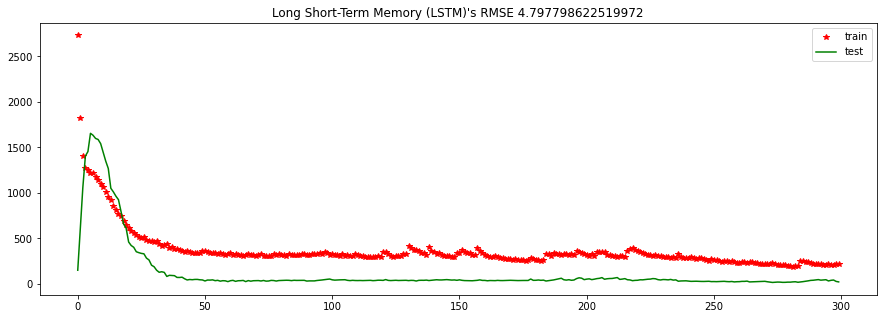

rmse:  4.797798622519972


In [129]:
plot_loss_history(model2, loss_his2, x_test2, y_test2)